In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score

# Загружаем данные
data = pd.read_csv('../data/credit_scoring_sample.csv', sep=";")

y = data["SeriousDlqin2yrs"].astype(int)
X = data.drop(["SeriousDlqin2yrs"], axis=1)
X = X.fillna(X.median())

# Инициализируем стратифицированную разбивку нашего датасета для валидации
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [3, 4, 5, 6, 7], 'min_samples_leaf': [3, 5]}
rfc = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=4, n_jobs=-1)
rfcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1, scoring='roc_auc')
rfcv.fit(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=4,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=-1,
                                              oob_

In [2]:
rfcv.best_estimator_, rfcv.best_score_

(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=4, max_features=3,
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=3, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                        oob_score=False, random_state=42, verbose=0,
                        warm_start=False), 0.8241468790443588)

In [3]:
parameters = {'max_features': [3, 4, 5, 6, 7], 'min_samples_leaf': [1, 3, 5], 'max_depth': [5,10,15,20]}
etc = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
etcv = GridSearchCV(etc, parameters, n_jobs=-1, cv=skf, verbose=1, scoring='roc_auc')
etcv.fit(X, y)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   26.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            oob_score=False, random_state=42,
                                   

In [4]:
etcv.best_estimator_, etcv.best_score_

(ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=20, max_features=5,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False), 0.8234071378454036)

Feature ranking:
1. NumberOfTimes90DaysLate 0.346244 
2. NumberOfTime30-59DaysPastDueNotWorse 0.289354 
3. NumberOfTime60-89DaysPastDueNotWorse 0.198681 
4. age 0.097753 
5. MonthlyIncome 0.026552 
6. NumberOfDependents 0.020913 
7. DebtRatio 0.020503 


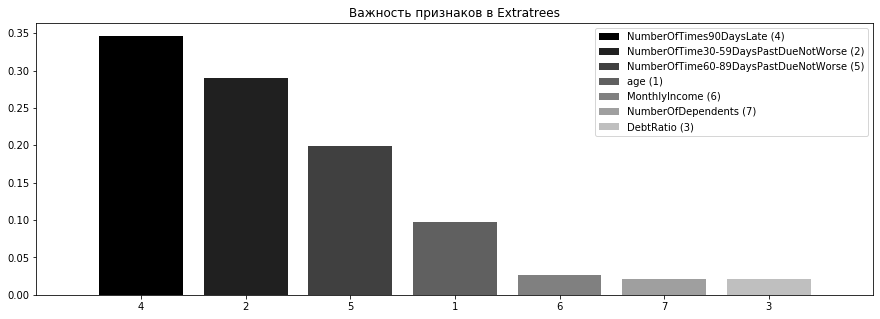

In [5]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt

importances = etcv.best_estimator_.feature_importances_
features = X.columns

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = len(features)
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features[feature_indices[f]-1], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность признаков в Extratrees")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features[i-1]) + " ({})".format(i) 
                  for i in feature_indices]);

In [6]:
rf = rfcv.best_estimator_
et = etcv.best_estimator_
rf_predictions = []
et_predictions = []

for train, val in skf.split(X, y):
    rf.fit(X.iloc[train], y[train])
    et.fit(X.iloc[train], y[train])
    rf_predictions.append([y[val], rf.predict_proba(X.iloc[val])[:,1]])
    et_predictions.append([y[val], et.predict_proba(X.iloc[val])[:,1]])

In [7]:
np.mean([roc_auc_score(i[0], i[1]) for i in rf_predictions]), np.mean([roc_auc_score(i[0], i[1]) for i in et_predictions])

(0.8241468790443588, 0.8234071335753175)

# Simple averaging

In [8]:
np.mean([roc_auc_score(rf_p[0], rf_p[1]*0.5 + et_p[1]*0.5) for rf_p, et_p in zip(rf_predictions, et_predictions)])

0.8255888871654822

# Geometric mean

In [9]:
np.mean([roc_auc_score(rf_p[0], np.sqrt(rf_p[1]*et_p[1])) for rf_p, et_p in zip(rf_predictions, et_predictions)])

0.8254447717550946

# Rank average

In [10]:
from scipy.stats import rankdata
np.mean([roc_auc_score(rf_p[0], rankdata(rf_p[1]) + rankdata(et_p[1])) for rf_p, et_p in zip(rf_predictions, et_predictions)])

0.8263121671820063

# Weighted average

In [17]:
np.mean([roc_auc_score(rf_p[0], rf_p[1]*0.75 + et_p[1]*0.25) for rf_p, et_p in zip(rf_predictions, et_predictions)])

0.8261090605303

# Blending

![img](https://alexanderdyakonov.files.wordpress.com/2017/03/stacking.png?w=1400)

# Stacking

![img](https://alexanderdyakonov.files.wordpress.com/2017/03/stacking-2b.png?w=1400)

Further reading: https://alexanderdyakonov.wordpress.com/2017/03/10/cтекинг-stacking-и-блендинг-blending/

In [18]:
X["rf_preds"] = 0
X["et_preds"] = 0

In [19]:
for i, fold in enumerate(skf.split(X, y)):
    train, val = fold[0], fold[1]
    X.iloc[val, -2] = rf_predictions[i][1]
    X.iloc[val, -1] = et_predictions[i][1]

In [20]:
X.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents,rf_preds,et_preds
0,64,0,0.249908,0,0,8158.0,0.0,0.073941,0.060658
1,58,0,3870.000000,0,0,5166.0,0.0,0.082821,0.071172
2,41,0,0.456127,0,0,6666.0,0.0,0.138232,0.117570
3,43,0,0.000190,0,0,10500.0,2.0,0.123030,0.109082
4,49,0,0.271820,0,0,400.0,0.0,0.130461,0.138185


In [21]:
parameters = {'max_features': [3, 4, 5, 6, 7], 'min_samples_leaf': [1, 3, 5], 'max_depth': [5,10,15,20]}
etc = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
etcv = GridSearchCV(etc, parameters, n_jobs=-1, cv=skf, verbose=1, scoring='roc_auc')
etcv.fit(X, y)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   31.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            oob_score=False, random_state=42,
                                   

In [22]:
etcv.best_score_

0.8283615523690123

Feature ranking:
1. rf_preds 0.426286 
2. et_preds 0.376238 
3. age 0.041384 
4. NumberOfTimes90DaysLate 0.035426 
5. NumberOfTime30-59DaysPastDueNotWorse 0.034189 
6. NumberOfTime60-89DaysPastDueNotWorse 0.032770 
7. MonthlyIncome 0.020093 
8. DebtRatio 0.017004 
9. NumberOfDependents 0.016610 


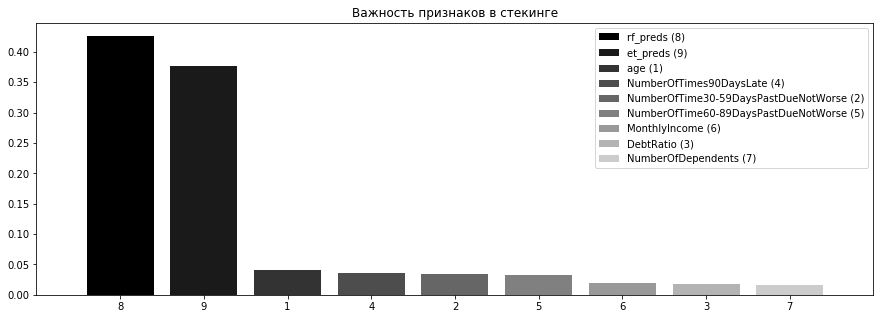

In [23]:
importances = etcv.best_estimator_.feature_importances_
features = X.columns

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = len(features)
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features[feature_indices[f]-1], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность признаков в стекинге")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features[i-1]) + " ({})".format(i) 
                  for i in feature_indices]);

In [24]:
np.corrcoef([X["rf_preds"], X["et_preds"]])

array([[1.        , 0.97347315],
       [0.97347315, 1.        ]])